# Multimodal RAG

## Overview

This notebook demonstrates how to build a Multimodal RAG (Retrieval-Augmented Generation) system using LangChain. The system processes both text and images from documents, creating a unified knowledge base for question-answering.

Key features include:
- Text content extraction to markdown using `pymupdf4llm`
- Image content extraction using `Upstage Document AI API`
- Text and image content merging by page
- RAG implementation using `OpenAI embeddings` and `GPT-4o`
- `Langgraph` based RAG pipeline

![Multimodal RAG Architecture]
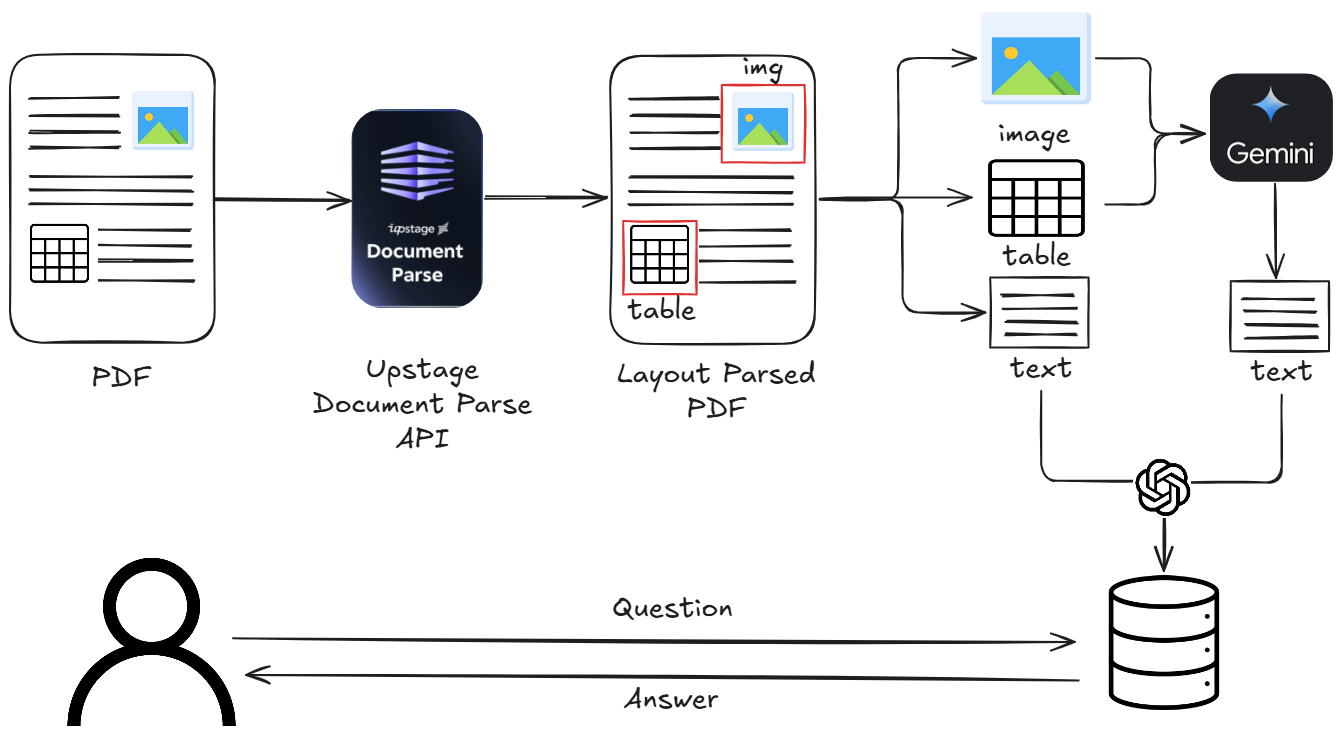

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment_setup)
- [Extract and preprocess Text contents from PDF using PyMuPDF4LLM](#extract-and-preprocess-text-contents-from-pdf-using-pymupdf4llm)
- [Layout parsing to extract image from PDF using Upstage Document Parse API](#layout-parsing-to-extract-image-from-pdf-using-upstage-document-parse-api)
- [Building a RAG Pipeline with LangGraph](#building-a-rag-pipeline-with-langgraph)

### References

- [PyMuPDF4LLM](https://pymupdf.readthedocs.io/en/latest/pymupdf4llm/api.html#pymupdf4llm-api)
- [Upstage Document AI](https://www.upstage.ai/blog/en/let-llms-read-your-documents-with-speed-and-accuracy)
- [Gemini in Langchain](https://python.langchain.com/docs/integrations/chat/google_generative_ai/)
- [Multimodal input in Langchain](https://python.langchain.com/docs/how_to/multimodal_inputs/)
---

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
# %%capture --no-stderr
# %pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "pymupdf4llm",
        "langchain-upstage",
        "langchain-google-genai",
        "langchain-chroma",
        "langchain-openai",       
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
import os
from dotenv import load_dotenv

# Load from .env file (auto-detects path)
load_dotenv() 

True

## Extract and preprocess Text contents from PDF using `PyMuPDF4LLM`
### `PyMuPDF4LLM`

`PyMuPDF4LLM` is a Python package designed to facilitate the extraction of PDF content into formats suitable for Large Language Models (LLMs) and Retrieval-Augmented Generation (RAG) environments. It supports Markdown extraction and LlamaIndex document output, making it a valuable tool for developing document-based AI applications.

### Key Features

- **Multi-Column Page Support**: Accurately extracts text from pages with multiple columns.

- **Image and Vector Graphics Extraction**: Extracts images and vector graphics from pages, including references in the Markdown text.

- **Page Chunking Output**: Outputs pages in chunks, facilitating use in LLM and RAG systems.

- **LlamaIndex Document Output**: Directly converts PDFs into LlamaIndex document format.

In [4]:
# # Install PyMuPDF4LLM using pip:
# %pip install pymupdf4llm

In [5]:
file_path = "../Data/PDFs/peksevim_rf_brief_2025_online.pdf"

In [6]:
import pymupdf4llm

# to_markdown() function extracts text content and converts it into markdown format
md_text = pymupdf4llm.to_markdown(
    doc=file_path,  # The file, either as a file path or a PyMuPDF Document.
    page_chunks=True,  # If True, output is a list of page-specific dictionaries.
    show_progress=True,  # Displays a progress bar during processing.
    # pages=[0, 1, 2],  - Optional, specify 0-based page numbers to process.
    # hdr_info=False,  - Optional, disables header detection logic.
    # write_images=True,  #- Saves images found in the document as files.
    # embed_images=True,  - Embeds images directly as base64 in markdown.
    # image_size_limit=0.05,  - Exclude small images below this size threshold.
    # dpi=150,  - Image resolution in dots per inch, if write_images=True.
    # image_path="output_images",  - Directory to save images if write_images=True.
    # image_format="png",  - Image file format, e.g., "png" or "jpg".
    # force_text=True,  - Include text overlapping images/graphics.
    # margins=0,  - Specify page margins for text extraction.
    # page_width=612,  - Desired page width for reflowable documents.
    # page_height=None,  - Desired page height for reflowable documents.
    # table_strategy="lines_strict",  #- Strategy for table detection.
    # graphics_limit=5000,  - Limit the number of vector graphics processed.
    # ignore_code=False,  - If True, avoids special formatting for mono-spaced text.
    # extract_words=False,  - Adds word-level data to each page dictionary.
)

Processing ../Data/PDFs/peksevim_rf_brief_2025_online.pdf...
[                                        ] (0/3[=                                       ] ( 1/3[==                                      ] ( 2/38[===                                     ] ( 3/3[====                                    ] ( 4/38[=====                                   ] ( 5/3[======                                  ] ( 6/38[=======                                 ] ( 7/3[========                                ] ( 8/38[=========                               ] ( 9/3[==========                              ] (10/38[===========                             ] (11/3[============                            ] (12/38[=============                           ] (13/3[==============                          ] (14/38[===============                         ] (15/3[================                        ] (16/38[=================                       ] (17/3[==================                      ] (18/38[==================

In [7]:
print(md_text[1]['text'])

-----




In [44]:
for page, text in enumerate(md_text[:15]):
    print(f"📄 **Page {page+1}**\n{'='*20}")
    print(f"{text['text'][:10000]}...")

📄 **Page 1**
##### CFA INSTITUTE RESEARCH FOUNDATION / BRIEF
# **OPTIMAL DESIGN OF ** **LIFE-CYCLE FUNDS IN ** **EMERGING MARKET ** **COUNTRIES**

**SEDA PEKSEVIM**


-----

...
📄 **Page 2**
-----

...
📄 **Page 3**
## **OPTIMAL DESIGN OF 
** **LIFE-CYCLE FUNDS IN ** **EMERGING MARKET ** **COUNTRIES**

**SEDA PEKSEVIM**


-----

...
📄 **Page 4**
#### Statement of Purpose

The CFA Institute Research Foundation is a not-for-profit organization established
to promote the development and dissemination of relevant research for investment
practitioners worldwide.

© 2025 CFA Institute Research Foundation. All rights reserved.

Neither CFA Institute Research Foundation, CFA Institute, nor the publication’s editorial staff is responsible
for facts and opinions presented in this publication. This publication reflects the views of the author(s)
and does not represent the official views of CFA Institute Research Foundation.

No part of this publication may be reproduced or transmitted in any form 

## Layout parsing to extract image from PDF using `Upstage Document Parse API`

The `Upstage Document Parse API` is a robust AI model that converts various document formats, including PDFs and images, into HTML by detecting layout elements such as paragraphs, tables, and images. This facilitates the integration of document content into applications requiring structured data.

**Key Features:**

- **Layout Detection:** Identifies and preserves document structures, including paragraphs, tables, and images.

- **Format Conversion:** Transforms documents into HTML, maintaining the original layout and reading order.

- **High Performance:** Processes documents swiftly, handling up to 100 pages per minute.
  
<img src="https://cdn.prod.website-files.com/6743d5190bb2b52f38e99ecd/674803bdd33f606f35b972bf_Upstage_DP_KV.png" alt="image" width="700">

Source: [Upstage Official Website](https://www.upstage.ai/blog/en/let-llms-read-your-documents-with-speed-and-accuracy)


### `UpstageDocumentParseLoader` in LangChain
The `UpstageDocumentParseLoader` is a component of the langchain_upstage package that integrates `Upstage's Document Parser API` into the LangChain framework. It enables seamless loading and parsing of documents within LangChain applications. 


In [9]:
# Install the langchain-upstage package using pip:
#%pip install -U langchain-upstage

In [10]:
from langchain_upstage import UpstageDocumentParseLoader

loader = UpstageDocumentParseLoader(
            file_path, split="page", 
            output_format="markdown",
            base64_encoding=["figure", "chart", "table"]
         )
docs = loader.load_and_split()

In [11]:
len(docs)

35

Inspect parsed documents to check for and display base64-encoded content along with a brief summary of each document's content and metadata.


In [12]:
for i, j in enumerate(docs[:14]):
    bs_encoding = j.metadata['base64_encodings']

    if len(bs_encoding) > 0:
        print(f"📄 **Page {i+1}**\n{'='*20}")
        print(f"📝 **Page Content Preview:** {j.page_content[:100]}...")
        print(f"🔑 **Metadata Keys:** {', '.join(j.metadata.keys())}")
        print(f"🖼️ **Base64 Encoding (Preview):** {bs_encoding[0][:10]}...")
        print("\n")

📄 **Page 9**
📝 **Page Content Preview:** Optimal Design of Life-Cycle Funds in Emerging Market Countries # 3. Data Our study uses two differe...
🔑 **Metadata Keys:** page, base64_encodings, coordinates
🖼️ **Base64 Encoding (Preview):** /9j/2wCEAA...


📄 **Page 10**
📝 **Page Content Preview:** Optimal Design of Life-Cycle Funds in Emerging Market Countries # Exhibit 2. Capital Market Assumpti...
🔑 **Metadata Keys:** page, base64_encodings, coordinates
🖼️ **Base64 Encoding (Preview):** /9j/2wCEAA...


📄 **Page 13**
📝 **Page Content Preview:** Optimal Design of Life-Cycle Funds in Emerging Market Countries # 5. Results # Stochastic Human Capi...
🔑 **Metadata Keys:** page, base64_encodings, coordinates
🖼️ **Base64 Encoding (Preview):** /9j/2wCEAA...


📄 **Page 14**
📝 **Page Content Preview:** Optimal Design of Life-Cycle Funds in Emerging Market Countries # Exhibit 4. Human Capital Distribut...
🔑 **Metadata Keys:** page, base64_encodings, coordinates
🖼️ **Base64 Encoding (Preview):** /9j/2

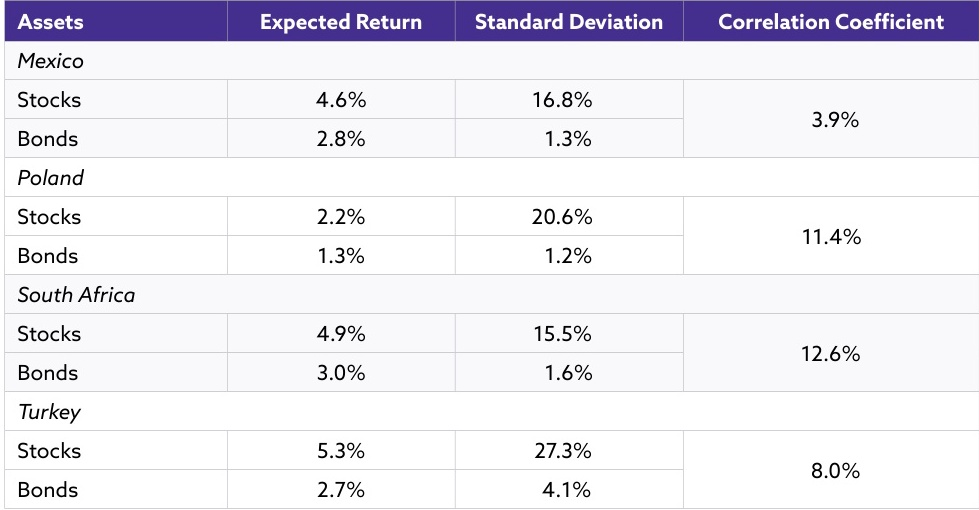

In [13]:
import base64
from IPython.display import Image, display

img_data = base64.b64decode(docs[9].metadata['base64_encodings'][0])  # Decode base64
display(Image(data=img_data))  # Display the image

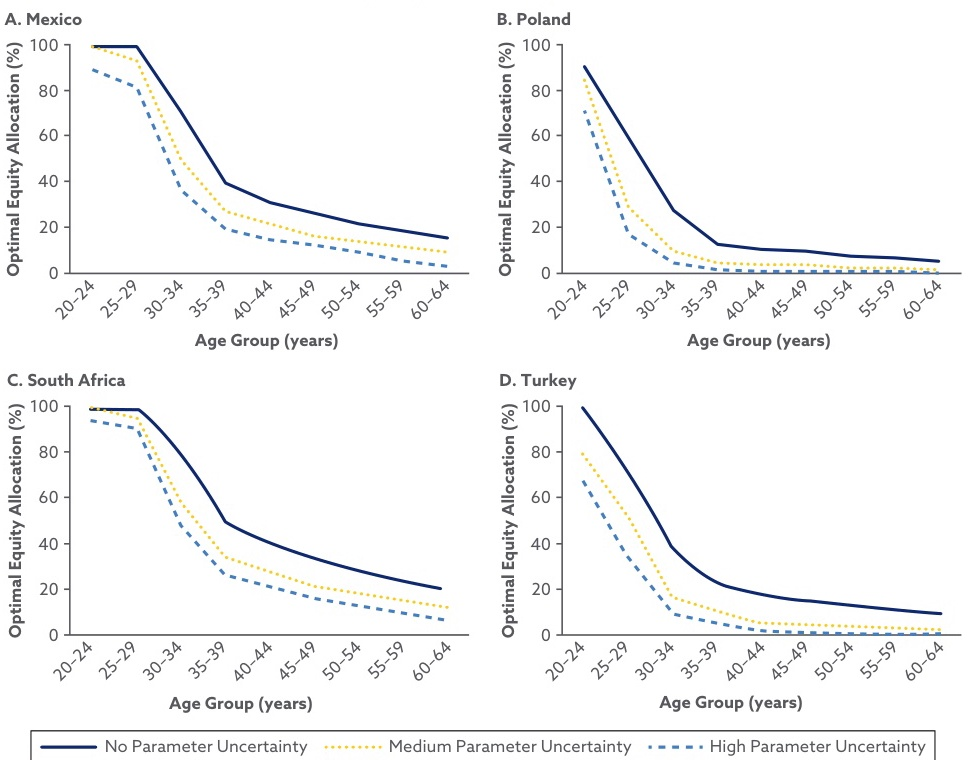

In [14]:
import base64
from IPython.display import Image, display

img_data = base64.b64decode(docs[23].metadata['base64_encodings'][0])  # Decode base64
display(Image(data=img_data))  # Display the image

This process generates multimodal descriptions of images detected on each page using the `Gemini 1.5 Flash 8B API`. These descriptions are combined with the previously extracted text to create a complete embedding, enabling a RAG pipeline capable of understanding images as well.

In [21]:
from langchain_core.documents import Document
from google.generativeai import configure, GenerativeModel
import base64
import os

configure()

def create_image_descriptions(docs):
    model = GenerativeModel("gemini-1.5-flash-8b")
    new_documents = []
    
    for doc in docs:
        if 'base64_encodings' in doc.metadata:
            for img_base64 in doc.metadata['base64_encodings']:
                try:
                    # Build the content package correctly
                    response = model.generate_content(
                        contents=[
                            {
                                "parts": [
                                    """
                                    Describe only the factual content visible in the image:

                                    1. If decorative/non-informational: output '<---image--->'

                                    2. For content images:
                                    - General Images: List visible objects, text, and measurable attributes
                                    - Charts/Infographics: State all numerical values and labels present
                                    - Tables: Convert to markdown table format with exact data

                                    Rules:
                                    * Include only directly observable information
                                    * Use original numbers and text without modification
                                    * Avoid any interpretation or analysis
                                    * Preserve all labels and measurements exactly as shown
                                    """,
                                    {
                                        "mime_type": "image/png",
                                        "data": base64.b64decode(img_base64)
                                    }
                                ]
                            }
                        ]
                    )
                    
                    # Extract text safely
                    if response.candidates:
                        description = response.candidates[0].content.parts[0].text
                    else:
                        description = "<---image--->"
                        
                except Exception as e:
                    print(f"Error processing image: {str(e)}")
                    description = "<---image--->"
                
                new_documents.append(
                    Document(
                        page_content=description,
                        metadata={"page": doc.metadata.get("page", "unknown")}
                    )
                )
    
    return new_documents

# Generate image descriptions
image_description_docs = create_image_descriptions(docs)


In [43]:
# Check the results
for doc in image_description_docs[:14]:
    print(f"📄 **Page {doc.metadata['page']}**\n{'='*20}")
    print(f"Description: {doc.page_content}")
    print("---")

📄 **Page 10**
Description: ```
Annual Real Earnings (15-24=100)

15-24:
Mexico: 100
Poland: 110
South Africa: 110
Turkey: 105

25-34:
Mexico: 150
Poland: 130
South Africa: 120
Turkey: 115

35-44:
Mexico: 185
Poland: 150
South Africa: 140
Turkey: 135

45-54:
Mexico: 175
Poland: 145
South Africa: 140
Turkey: 125

55-64:
Mexico: 155
Poland: 140
South Africa: 170
Turkey: 120
```
---
📄 **Page 11**
Description: | Assets | Expected Return | Standard Deviation | Correlation Coefficient |
|---|---|---|---|
| Mexico Stocks | 4.6% | 16.8% | 3.9% |
| Bonds | 2.8% | 1.3% |  |
| Poland Stocks | 2.2% | 20.6% | 11.4% |
| Bonds | 1.3% | 1.2% |  |
| South Africa Stocks | 4.9% | 15.5% | 12.6% |
| Bonds | 3.0% | 1.6% |  |
| Turkey Stocks | 5.3% | 27.3% | 8.0% |
| Bonds | 2.7% | 4.1% |  |
---
📄 **Page 14**
Description: Median: 3,367,301
Std Dev: 1,466,284
99%: 8
95%: 6
90%: 6
75%: 4
50%: 3
25%: 2
10%: 2
5%: 2
1%: 1
---
📄 **Page 14**
Description: Median: 3,456,244
Std Dev: 2,018,853
Human Capital (Mexican p

In [30]:
from langchain_core.documents import Document
from collections import defaultdict

def merge_text_and_images(md_text, image_description_docs):
    # Create a dictionary to collect data by page
    page_contents = defaultdict(list)
    page_metadata = {}
    
    # Process md_text
    for text_item in md_text:
        # Standardize page numbers to integer
        page = int(text_item['metadata']['page'])
        page_contents[page].append(text_item['text'])
        # Save metadata for each page
        if page not in page_metadata:
            page_metadata[page] = {
                'source': text_item['metadata']['file_path'],
                'page': page
            }
    
    # Process image_description_docs
    for img_doc in image_description_docs:
        # Standardize page numbers to integer
        page = int(img_doc.metadata['page'])
        page_contents[page].append(img_doc.page_content)
    
    # Create the final list of Document objects
    merged_docs = []
    for page in sorted(page_contents.keys()):
        # Combine all content of the page into a single string
        full_content = '\n\n'.join(page_contents[page])
        
        # Create a Document object
        doc = Document(
            page_content=full_content,
            metadata=page_metadata[page]
        )
        merged_docs.append(doc)
    
    return merged_docs

In [31]:
merged_documents = merge_text_and_images(md_text, image_description_docs)

In [42]:
print(merged_documents[13].page_content)

Optimal Design of Life-Cycle Funds in Emerging Market Countries
#### **5. Results**
###### Stochastic Human Capital Analysis

We report the findings for stochastic human capital based on a representative investor who
begins working at age 20 and will retire at age 65 (with the assumption of zero human capital
at that age). The simulation process is based on 100,000 Monte Carlo replications of the labor
income process.

**Exhibits 3 through 6** present the stochastic human capital distributions, along with their
medians and standard deviations, in four EM countries—Mexico, Poland, South Africa, and
Turkey—for ages 20, 30, 45, and 60. In Mexico and South Africa, median human capital rises
slightly between age 20 and age 30 and then declines at age 45, reaching its lowest level at
age 60. Conversely, in Turkey and Poland, median human capital declines slightly from ages
20 to 30 to 45, reaching its lowest level at age 60.
###### Exhibit 3. Human Capital Distributions in Mexico, by Age


*

## Building a RAG Pipeline with `LangGraph`

This guide demonstrates how to use `LangGraph` to build a unified RAG (Retrieval-Augmented Generation) application. By combining retrieval and generation into a single flow, `LangGraph` offers streamlined execution, deployment, and additional features like persistence and human-in-the-loop approval.

### Key Components

1. **Application State**:
   - Tracks input (`question`), intermediate (`context`), and output (`answer`) data using a `TypedDict`.

2. **Application Steps**:
   - **Retrieve**: Uses `Chroma` for similarity-based document retrieval.
   - **Generate**: Formats retrieved context and question, then invokes `ChatOpenAI` to generate an answer.

3. **Control Flow**:
   - Uses `StateGraph` to define the sequence and connections between steps.

In [34]:
import os
from dotenv import load_dotenv
from langchain_text_splitters import RecursiveCharacterTextSplitter  
from langchain_openai import OpenAIEmbeddings                     
from langchain.vectorstores import Pinecone as LangPinecone   
import pinecone
from pinecone import Pinecone as PineconeClient, ServerlessSpec

load_dotenv() 
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

pc = PineconeClient(
    api_key=os.getenv("PINECONE_API_KEY"),
    environment=os.getenv("PINECONE_ENVIRONMENT")
)                                         
index_name = "cma-docs-2004-2022"
if index_name not in pc.list_indexes().names():  
    pc.create_index(
        name=index_name,
        dimension=1536,                      
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)                                           
all_splits = text_splitter.split_documents(merged_documents)

vector_store = LangPinecone.from_documents(
    documents=all_splits,
    embedding=embeddings,
    index_name=index_name      
)                                      

In [50]:
# 6) Perform similarity search, asking for the top 10 results
retrieved_docs = vector_store.similarity_search(
    "Human Capital Distributions in Mexico, for age 30, what is the mean",
    k=10
)

# 7) Print out the top-10 matches
for i, doc in enumerate(retrieved_docs, start=1):
    print(f"--- Result #{i} ---")
    print(doc.page_content[:1000].strip())     # show the first 300 characters
    print("…")
    print("Metadata:", doc.metadata)
    print()

--- Result #1 ---
**Percentile**

**D. Stochastic Human Capital (Age 60)**




3

2

1

0


1

0


99% 95% 90% 75% 50% 25% 10% 5% 1%

**Percentile**


99% 95% 90% 75% 50% 25% 10% 5% 1%

**Percentile**


Because labor income shocks and discount rates are modeled identically for each country, [7]
these differences are primarily attributed to the differences in labor income profiles shown in
Exhibit 1. For example, in countries where labor income either decreases moderately (Mexico) or
increases steadily (South Africa) at older ages, human capital at age 20 is higher compared with
age 30. In Poland and Turkey, however, flatter labor income profiles result in lower human capital
accumulation at age 20 relative to age 30, as earnings increase more gradually during early
working years.
…
Metadata: {'page': 15.0, 'source': '../Data/PDFs/peksevim_rf_brief_2025_online.pdf'}

--- Result #2 ---
**Exhibit 1** shows annual real labor income (standardized to 100 for the 15–24 age group) across
diffe

In [47]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

llm = ChatOpenAI(model="gpt-4o-mini")

prompt = ChatPromptTemplate([
    ("human", """
You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Question: {question} 
Context: {context} 
Answer:
""")])

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    print(f"SEARCHING DOCUMENTS...\n{'='*20}")
    retrieved = vector_store.similarity_search(state["question"])
    print(f"Top hit preview:\n{retrieved[0].page_content[:100]}\n{'='*20}")
    return {"context": retrieved}

def generate(state: State):
    print(f"GENERATING ANSWER...\n{'='*20}")
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

response = graph.invoke({"question": "Human Capital Distributions in Mexico, for age 30, what is the mean"})
print(response["answer"])

SEARCHING DOCUMENTS...
Top hit preview:
**Percentile**

**D. Stochastic Human Capital (Age 60)**




3

2

1

0


1

0


99% 95% 90% 75% 50%
GENERATING ANSWER...
The mean human capital distribution in Mexico for age 30 is not explicitly stated in the provided context. However, it does mention that for age 30, the stochastic human capital is represented by a value of 12. If you are looking for the mean specifically, that information is not available in the retrieved context.


As shown in the image below, the answer was correctly predicted.

In [ ]:
import base64
from IPython.display import Image, display

img_data = base64.b64decode(docs[9].metadata['base64_encodings'][0])  # Decode base64
display(Image(data=img_data))  # Display the image